# mag2exp: Torque magnetometry

This notebook is designed to go with the ______ paper and showcase the code and the techniques that `mag2exp` included in the paper.

In [1]:
%config InlineBackend.figure_formats = ['svg']

Import packages

In [2]:
import discretisedfield as df
import micromagneticmodel as mm
import oommfc as oc
import numpy as np
from tqdm import tqdm
import mag2exp
import micromagneticdata as mmd
import matplotlib.pyplot as plt
plt.style.use('default')

Define the energy terms and the initial magnetisation of the micromagnetic simulation.

In [3]:
system = mm.System(name="Torque_simulation")

H_max = 3/mm.consts.mu0 # 3 T
angle = 1 *np.pi/180  # Missalign the applied field by 1 degree to break symmtry.
system.energy = (mm.Exchange(A=1.6e-11)
                 + mm.DMI(D=4e-3, crystalclass='T')
                 + mm.UniaxialAnisotropy(K=5.1e5, u=(0, 0, 1))
                 + mm.Demag()
                 + mm.Zeeman(H=(0, H_max*np.sin(angle), H_max*np.cos(angle))))
system.energy

Exchange(A=1.6e-11) + DMI(D=0.004, crystalclass='T') + UniaxialAnisotropy(K=510000.0, u=(0, 0, 1)) + Demag() + Zeeman(H=(0, 41664.551300137275, 2386960.5453476724))

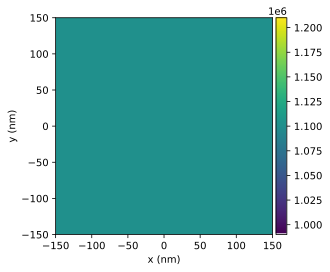

In [4]:
Ms = 1.1e6  # A/m
region = df.Region(p1=(-150e-9, -150e-9, -20e-9), p2=(150e-9, 150e-9, 0))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))
system.m = df.Field(mesh, dim=3, value=(0, 0, 1), norm=Ms)
system.m.plane('z').z.mpl()

Running OOMMF (ExeOOMMFRunner)[2022/07/11 19:58]... (0.5 s)


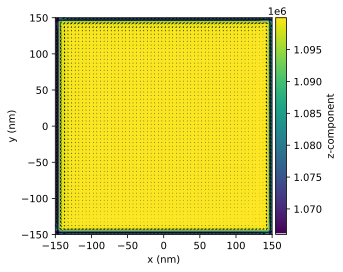

In [5]:
md = oc.MinDriver()
md.drive(system)

# Plot relaxed configuration: vectors in z-plane
system.m.plane('z').mpl()

In [6]:
def plot_torque():
    plt.style.use('default')
    fig, ax = plt.subplots(2, 1, figsize=(5,7))
    ax[0].scatter(angles, [i[0] for i in torque_arr])
    ax[0].hlines(system.energy.uniaxialanisotropy.K, xmin=np.min(angles), xmax=np.max(angles), color='r')
    ax[0].hlines(-system.energy.uniaxialanisotropy.K, xmin=np.min(angles), xmax=np.max(angles), color='r')

    ax[0].set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    ax[0].set_xticklabels(['0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$', r'$2\pi$'])
    ax[0].set_yticks([-4e5, -2e5, 0, 2e5, 4e5])
    ax[0].set_yticklabels([r'$-4 \times 10 ^{5}$', r'$-2 \times 10 ^{5}$', '0', r'$2 \times 10 ^{5}$', r'$4 \times 10 ^{5}$'])
    ax[0].set_xlabel("Angle (rad.)")
    ax[0].set_ylabel(r"Torque (Nm$^{-2}$)")
    ax[0].set_xlim([0, 2*np.pi])
    ax[0].text(-0.25, system.energy.uniaxialanisotropy.K*0.96, r'$K$')
    ax[0].text(-0.45, -system.energy.uniaxialanisotropy.K*1.04, r'$-K$')
    
    idx = 52
    sweep_data = mmd.Data(system.name)
    angle = angles[idx]
    sweep_data[idx].m0.orientation.plane('z').mpl(ax=ax[1], scalar_kw={'colorbar_label': r'$M_z$ (Ms)', 'clim': (-1, 1), 'cmap': 'coolwarm'})
    ax[1].set_title(f'Applied field\n (0,{H_max*np.sin(angle)*mm.consts.mu0:.2f},{H_max*np.cos(angle)*mm.consts.mu0:.2f}) T')
    fig.tight_layout()
    plt.show()

In [7]:
angles = np.linspace(0, 2*np.pi, 2*71)

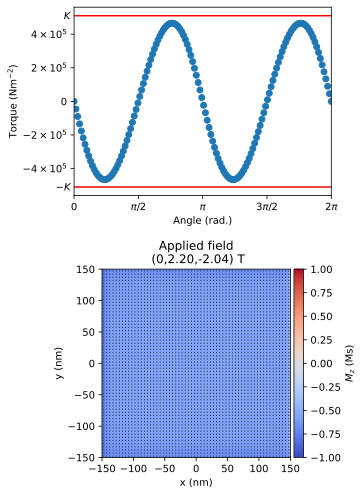

In [8]:
torque_arr = []
for angle in angles:
    system.energy.zeeman.H= (0,H_max*np.sin(angle),H_max*np.cos(angle))
    md.drive(system, verbose=0)
    torque_arr.append(mag2exp.magnetometry.torque(system.m, system.energy.zeeman.H))

plot_torque()  # Use matplotlib to plot